
# Explainability in Machine Learning with SHAP (Financial Use Case)

**Session goals**
- Understand *why* explainability matters in finance (trust, regulation, debugging).
- Learn how **SHAP** (Shapley Additive exPlanations) explains model predictions globally and locally.
- Apply SHAP to a **Random Forest** trained on a **credit risk** dataset.
- Practice interpreting explanations and turning them into business insights.



## 1. Why Explainability in Finance?

- **Regulation & Compliance:** Many jurisdictions require explainable decisions for lending/credit scoring.
- **Trust & Adoption:** Business users and auditors need to understand *why* predictions are made.
- **Debugging & Governance:** Explanations help detect data leakage, bias, or spurious correlations.

> **Key idea:** SHAP assigns each feature a contribution to a prediction, grounded in Shapley values from cooperative game theory.



## 2. Setup


In [1]:

# If running locally and you don't have these installed, uncomment:
# !pip install pandas numpy scikit-learn shap matplotlib openpyxl requests

import os
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

import shap

# Enable interactive JS for force plots
shap.initjs()


## 3. Load the Financial Dataset (UCI Credit Default)

We'll auto-download the **Default of Credit Card Clients** dataset from the UCI Machine Learning Repository.
If the first URL fails, a fallback mirror is tried.

**Target:** `default_payment_next_month` (1 = default, 0 = non-default)


In [2]:

import requests

def download_uci_credit_default():
    urls = [
        # Primary UCI link
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
        # Backup mirror (if available)
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    ]
    for url in urls:
        try:
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            return io.BytesIO(r.content)
        except Exception as e:
            print(f"Failed to download from {url}: {e}")
    raise RuntimeError("Could not download dataset from UCI. Please check connectivity or replace URL.")

bio = download_uci_credit_default()
# The relevant sheet is usually the first; header row is at row 1
df_raw = pd.read_excel(bio, header=1)

# Standardize column names
df_raw.columns = [str(c).strip().lower().replace(" ", "_").replace("-", "_") for c in df_raw.columns]

# Rename target for convenience if needed
if "default_payment_next_month" in df_raw.columns:
    df_raw.rename(columns={"default_payment_next_month": "default"}, inplace=True)

df_raw.head()


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


| Feature     | Description                                                                         | Example Values     |
| ----------- | ----------------------------------------------------------------------------------- | ------------------ |
| `LIMIT_BAL` | Amount of given credit (NT dollar), includes individual and family credit.          | 20,000 – 1,000,000 |
| `SEX`       | Gender (1 = male, 2 = female).                                                      | 1, 2               |
| `EDUCATION` | Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others). | 1–4                |
| `MARRIAGE`  | Marital status (1 = married, 2 = single, 3 = others).                               | 1–3                |
| `AGE`       | Age in years.                                                                       | 21–79              |


| Month (2005)  | Repayment Status (`PAY_X`)              | Bill Amount (`BILL_AMTX`)                     | Payment Amount (`PAY_AMTX`)           | What It Means                                                                                                |
| ------------- | --------------------------------------- | --------------------------------------------- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **September** | `PAY_0` — repayment status in September | `BILL_AMT1` — amount owed at end of September | `PAY_AMT1` — amount paid in September | The most recent month before prediction (October). Captures latest payment behavior and outstanding balance. |
| **August**    | `PAY_2` — repayment status in August    | `BILL_AMT2` — amount owed at end of August    | `PAY_AMT2` — amount paid in August    | Shows whether the client was starting to delay payments or carrying a growing balance.                       |
| **July**      | `PAY_3` — repayment status in July      | `BILL_AMT3` — bill at end of July             | `PAY_AMT3` — amount paid in July      | Midpoint of the 6-month history — reveals repayment trends.                                                  |
| **June**      | `PAY_4` — repayment status in June      | `BILL_AMT4` — bill at end of June             | `PAY_AMT4` — amount paid in June      |                                                                                                              |
| **May**       | `PAY_5` — repayment status in May       | `BILL_AMT5` — bill at end of May              | `PAY_AMT5` — amount paid in May       |                                                                                                              |
| **April**     | `PAY_6` — repayment status in April     | `BILL_AMT6` — bill at end of April            | `PAY_AMT6` — amount paid in April     | The oldest month in the dataset — starts the 6-month lookback period.                                        |


💳 1. Repayment Status Columns (PAY_0 – PAY_6)

| Value   | Meaning                              | Interpretation                                                      |
| ------- | ------------------------------------ | ------------------------------------------------------------------- |
| **-2**  | No consumption that month            | The client didn’t use the card at all, so there was no bill due.    |
| **-1**  | Paid in full                         | Client cleared the balance completely — healthy repayment behavior. |
| **0**   | Paid the minimum due or paid on time | Normal, revolving behavior; no delay.                               |
| **1**   | Payment delayed by 1 month           | Slight delay — mild risk signal.                                    |
| **2**   | Payment delayed by 2 months          | Missed two consecutive billing cycles — higher risk.                |
| **3–9** | Payment delayed by 3–9 months        | Serious delinquency — strong default indicator.                     |

🧾 2. Bill Statement Amount Columns (BILL_AMT1 – BILL_AMT6)

| Value Type                        | Meaning                  | Interpretation                                             |
| --------------------------------- | ------------------------ | ---------------------------------------------------------- |
| **Positive value (e.g., 50,000)** | Outstanding bill balance | The total amount owed by the end of that month.            |
| **0**                             | No balance               | The client had no outstanding credit card debt that month. |
| **Negative (rare)**               | Overpayment / refund     | Occasionally occurs if the client paid more than owed.     |


💵 3. Payment Amount Columns (PAY_AMT1 – PAY_AMT6)
| Value Type                       | Meaning                 | Interpretation                                                              |
| -------------------------------- | ----------------------- | --------------------------------------------------------------------------- |
| **Positive value (e.g., 5,000)** | Amount paid that month  | How much the client paid to reduce their balance.                           |
| **0**                            | No payment made         | Could indicate missed payment, especially if there was an outstanding bill. |
| **Very large value**             | Full or advance payment | The client paid off or exceeded their balance.                              |



## 4. Quick EDA

Let's explore the schema and class balance.


In [3]:

print("Shape:", df_raw.shape)
print("\nColumns:", list(df_raw.columns))
print("\nTarget distribution (default):")
print(df_raw["default"].value_counts(normalize=True).rename("share"))

df_raw.describe(include="all").T.head(15)


Shape: (30000, 25)

Columns: ['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default']

Target distribution (default):
default
0    0.7788
1    0.2212
Name: share, dtype: float64


,count,mean,std,min,25%,50%,75%,max
id,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
sex,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
education,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
marriage,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
pay_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


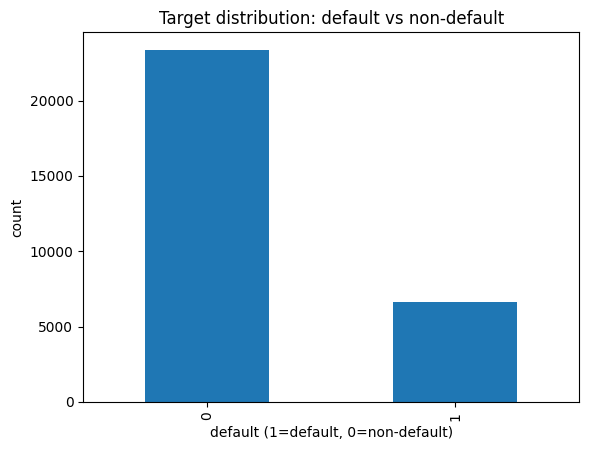

In [4]:
# Visualize target distribution
df_raw["default"].value_counts().plot(kind="bar")
plt.title("Target distribution: default vs non-default")
plt.xlabel("default (1=default, 0=non-default)")
plt.ylabel("count")
plt.show()



## 5. Minimal Cleaning & Feature Selection

We'll keep numeric/coded features as-is for a tree model. You can extend this step with domain-driven cleaning.


In [5]:

# Drop obvious non-feature if present
drop_cols = [c for c in ["id"] if c in df_raw.columns]
df = df_raw.drop(columns=drop_cols, errors="ignore").copy()

# Train/validation split
X = df.drop(columns=["default"])
y = df["default"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((24000, 23), (6000, 23))


## 6. Train a Random Forest Classifier


Validation ROC-AUC: 0.773

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



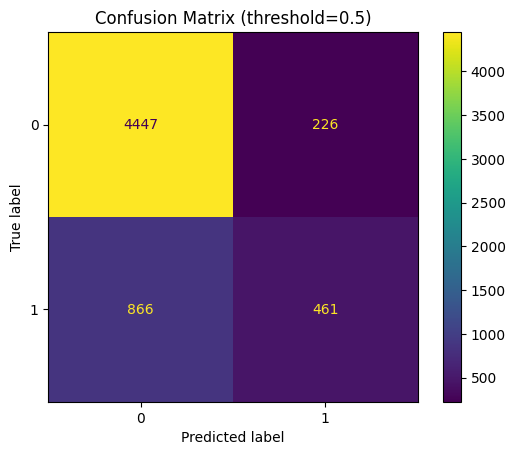

In [6]:
#random forest -> decision tree
# Define a Random Forest model tuned for explainability and speed
rf = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest.
                              # Fewer trees make the model faster to train and explain with SHAP.
                              # (400+ trees could slightly improve accuracy but slow things down.)

    max_depth=8,              # Maximum depth of each tree.
                              # Limits how many decision splits each tree can make.
                              # Shallow trees (e.g., depth=8) are easier to interpret and prevent overfitting.

    min_samples_split=5,      # Minimum number of samples required to split an internal node.
                              # Prevents the model from creating very small, unreliable splits.

    min_samples_leaf=4,       # Minimum number of samples required to be at a leaf node.
                              # Each final decision (leaf) must represent at least 4 training samples,
                              # which improves generalization and model stability.

    n_jobs=-1,                # Use all available CPU cores for parallel training to speed things up.
                              #if i am doing sth else in bckgrd then write 6/4 for this

    random_state=42           # Random seed for reproducibility.
                              # Ensures you get the same results every time you run this code.
)


rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)
print(f"Validation ROC-AUC: {auc:.3f}")

print("\nClassification report (threshold=0.5):")
pred = (proba >= 0.5).astype(int)
print(classification_report(y_test, pred))

disp = ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()

#precision: gbt kam 7ad 1 w howa 1 f3ln


## 7. Explainability with SHAP


In [7]:
#we use shap values 3shan nfham el model results from 6. leh this accuracy and so on?
import shap

# Newer, unified SHAP API — automatically picks the right explainer
explainer = shap.Explainer(rf, X_train)

# Compute SHAP values (returns a modern Explanation object)
shap_values_ebm = explainer(X_test)


100%|===================| 11982/12000 [02:26<00:00]       

In [8]:
#shap value> without knowing anything about customer what is expected value of default/nondefault (base value)
#if model is right it should have similar results to expected to be a good model

# Handle output format across SHAP versions:
# - If list, index 1 is positive class
# - If numpy array, it's already the correct shape
if isinstance(shap_values_ebm, list):
    shap_vals_pos = shap_values_ebm[1]
else:
    shap_vals_pos = shap_values_ebm

expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
print(f"\nExpected value (baseline): {expected_value:.3f}")



Expected value (baseline): 0.240


In [9]:

print( f"""
Business interpretation:
- The model’s average predicted probability of default is about {expected_value:.1%}.
- This represents the 'baseline risk' — the expected default rate across all clients,
  before considering any personal or behavioral features.
- Each customer’s SHAP values then push this baseline up or down depending on their profile:
    * Positive total SHAP effect → higher-than-average default risk
    * Negative total SHAP effect → lower-than-average default risk
"""
)



Business interpretation:
- The model’s average predicted probability of default is about 24.0%.
- This represents the 'baseline risk' — the expected default rate across all clients,
  before considering any personal or behavioral features.
- Each customer’s SHAP values then push this baseline up or down depending on their profile:
    * Positive total SHAP effect → higher-than-average default risk
    * Negative total SHAP effect → lower-than-average default risk




### 7.1 Global Feature Importance (SHAP Summary Plot)
- **What it shows:** Overall impact of each feature on the model's predictions.
- **Reading tips:** Higher position = more important; color indicates feature value (high vs low); horizontal spread indicates effect magnitude.


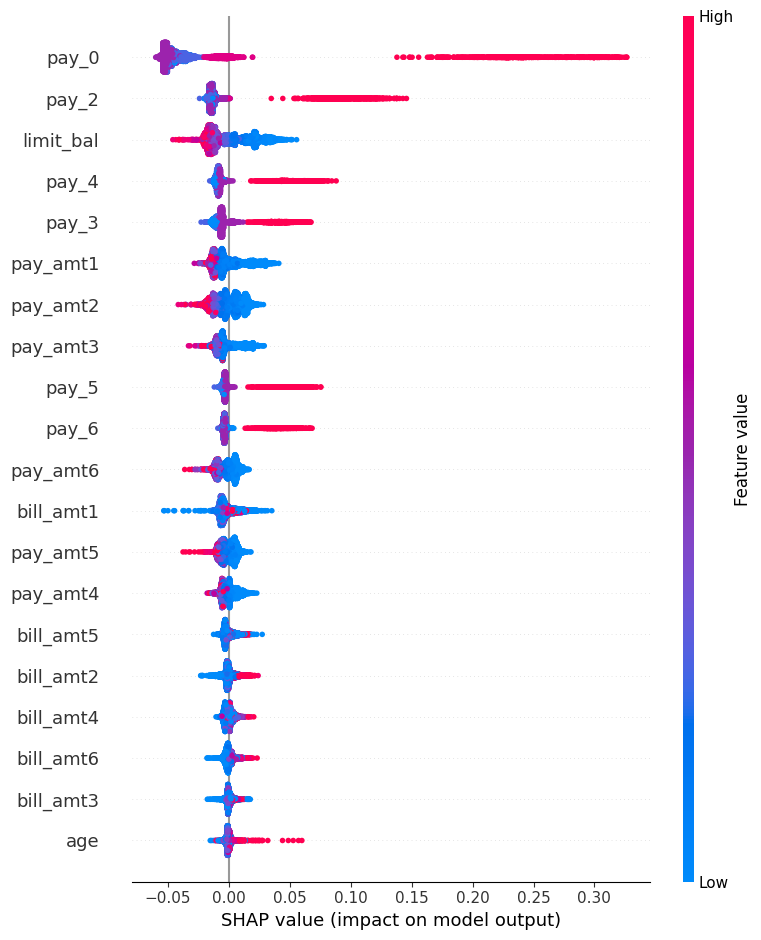

In [10]:
#overall imp of feature in model while local means the feature at a specific row

shap.summary_plot(shap_values_ebm[:, :, 1], X_test)

#if feature inc alot zy pay_0 then it will have a bigger impact (most probab hy default) than maslan apy_2
#how to understand what is below: i accumlate ay point mn below 3la el base value -> pay_0 is syaing en if
#someone did not pay last month then before going to any other feature howa hy default


### 7.2 Local Explanations (Per-Applicant)

We'll inspect a single applicant's prediction with an **interactive force plot** (requires JS).  
This shows how each feature pushes the prediction **higher** (towards default) or **lower** (towards non-default).


In [12]:
shap.initjs()
# Step 3 — Pick one sample to visualize
i = 0  # change this index to view other clients (we are looking here what is happeing at the first row of the dataset)

shap.plots.force(
    explainer.expected_value[1],      # baseline for "default" class
    shap_values_ebm.values[i, :, 1],  # SHAP values for that instance and class
    X_test.iloc[i, :],                # actual feature values for that client
show=True
)

#all in blue za2o to the left from base by the amount they have a blue part above them -> inc as such prob to not default
#all in red za2o to the right towards prob of defaulting

#above code is picking someone randomly -> if u want specifc play with the i in the ()
#the one below is not defaulting prob bec its at 0.12 mawslah lel cutoff point (50%)

In [14]:
shap.initjs()

# Step 3 — Pick one sample to visualize
i = 28  # change this index to view other clients

shap.plots.force(
    explainer.expected_value[1],      # baseline for "default" class
    shap_values_ebm.values[i, :, 1],  # SHAP values for that instance and class
    X_test.iloc[i, :],                # actual feature values for that client
    show=True
)
#if i want to inc the recall-> ha lower threshold

#the one below is most likely defaulting (passed the cutoff of 50%)